****Penerapan Algoritma _Clustering_ untuk Pengelompokkan Saham IDX Berdasarkan Indikator-indikator Fundamental - Submission Machine Learning Terapan Dicoding**** 

oleh: Fikri Septrian Anggara (fikri_anggara_2c3r)

### Import library yang diperlukan

In [2]:
# untuk pengolahan data
import pandas as pd

# untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# untuk pembangunan klaster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# untuk visualisasi klaster
from scipy.cluster.hierarchy import dendrogram, linkage

# untuk scaling data
from sklearn.preprocessing import MinMaxScaler

# untuk menghitung jarak
from scipy.spatial.distance import pdist, cdist

# untuk menghitung evaluasi klaster
from sklearn.metrics import silhouette_score

# untuk melakukan reduksi dimensi
from sklearn.decomposition import PCA

# 2. Data Understanding

### 2.1. Menyiapkan Dataset
dataset diperoleh dari kaggle, terdapat dua dataset yang digunakan yaitu:
 - [financial statement idx stocks](https://www.kaggle.com/datasets/greegtitan/financial-statement-idx-stocks?resource=download) (kaggle). terakhir diupdate pada Oktober 2022.
 - [daftar saham](https://www.kaggle.com/datasets/muamkh/ihsgstockdata?select=DaftarSaham.csv) (kaggle). terakhir diupdate pada Januari 2023

In [3]:
# load data
stockQuarter = pd.read_csv('data/quarter.csv')
masterStock = pd.read_csv('data/DaftarSaham.csv')

### 2.2. Overview Data
pada tahap ini dilakukan _overview_ pada data stockQuarter dan masterStock

In [4]:
# banyaknya baris dan kolom (baris, kolom)
print(stockQuarter.shape)
print(masterStock.shape)

(208691, 8)
(829, 14)


In [5]:
# kolom dan tipe data
stockQuarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208691 entries, 0 to 208690
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   symbol      208691 non-null  object 
 1   account     208691 non-null  object 
 2   type        208149 non-null  object 
 3   2021-09-30  51722 non-null   float64
 4   2021-12-31  51538 non-null   float64
 5   2022-03-31  53449 non-null   float64
 6   2022-06-30  50375 non-null   float64
 7   2022-09-30  17013 non-null   float64
dtypes: float64(5), object(3)
memory usage: 12.7+ MB


In [6]:
# kolom dan tipe data
masterStock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                829 non-null    object 
 1   Name                829 non-null    object 
 2   ListingDate         829 non-null    object 
 3   Shares              829 non-null    float64
 4   ListingBoard        829 non-null    object 
 5   Sector              829 non-null    object 
 6   LastPrice           824 non-null    float64
 7   MarketCap           824 non-null    float64
 8   MinutesFirstAdded   787 non-null    object 
 9   MinutesLastUpdated  787 non-null    object 
 10  HourlyFirstAdded    806 non-null    object 
 11  HourlyLastUpdated   806 non-null    object 
 12  DailyFirstAdded     824 non-null    object 
 13  DailyLastUpdated    824 non-null    object 
dtypes: float64(3), object(11)
memory usage: 90.8+ KB


In [7]:
# ambil sampel random sebanyak 5 data
stockQuarter.sample(n=5, random_state=1)


,symbol,account,type,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30
181194,SQMI,CF,Cash From Discontinued Investing Activities,NaN,NaN,NaN,NaN,NaN
137781,MSKY,CF,Paymentson Behalfof Employees,-8.421300e+10,-7.747800e+10,-6.249900e+10,-6.643200e+10,NaN
22706,BBHI,BS,Long Term Debt And Capital Lease Obligation,4.114605e+09,3.291684e+09,0.000000e+00,4.575037e+10,4.135613e+10
143195,NETV,IS,Credit Card,NaN,NaN,NaN,NaN,NaN
184286,SUPR,BS,Securities And Investments,NaN,NaN,NaN,NaN,NaN


In [8]:
stockQuarter.isnull().sum()

symbol             0
account            0
type             542
2021-09-30    156969
2021-12-31    157153
2022-03-31    155242
2022-06-30    158316
2022-09-30    191678
dtype: int64

- terdapat banyak ****null value**** pada data saham perkuarter

In [10]:
# ambil sampel random sebanyak 5 data
masterStock.sample(n=5, random_state=1)

,Code,Name,ListingDate,Shares,ListingBoard,Sector,LastPrice,MarketCap,MinutesFirstAdded,MinutesLastUpdated,HourlyFirstAdded,HourlyLastUpdated,DailyFirstAdded,DailyLastUpdated
370,INTA,Intraco Penta Tbk.,1993-08-23,3.343935e+09,Pengembangan,Industrials,74.0,2.474512e+11,2021-11-01 09:00:00,2022-06-03 15:59:00,2020-04-16 09:00:00,2022-06-03 16:00:00,2001-04-16,2023-01-06
449,LION,Lion Metal Works Tbk.,1993-08-20,5.201600e+08,Utama,Industrials,735.0,3.823176e+11,2021-11-01 09:00:00,2023-01-06 15:59:00,2020-04-16 09:00:00,2023-01-06 15:00:00,2001-04-16,2023-01-06
810,WINR,Winner Nusantara Jaya Tbk.,2022-04-25,5.235200e+09,Utama,Properties & Real Estate,50.0,2.617600e+11,2022-04-25 09:00:00,2023-01-06 15:59:00,2022-04-25 09:00:00,2023-01-06 15:00:00,2022-04-25,2023-01-06
578,PDPP,Primadaya Plastisindo Tbk.,2022-11-09 00:00:00,2.500000e+09,Pengembangan,Basic Materials,202.0,5.050000e+11,2022-11-09 09:00:00,2023-01-06 15:59:00,2022-11-09 09:00:00,2023-01-06 15:00:00,2022-11-10,2023-01-06
700,SMRU,SMR Utama Tbk.,2011-10-10,1.249939e+10,Pengembangan,Energy,50.0,6.249693e+11,NaN,NaN,NaN,NaN,2011-10-10,2023-01-06


In [11]:
# 5 number summary stock quarter
stockQuarter.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
symbol,208691,544,AALI,391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account,208691,3,BS,73461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,208149,388,Interest Received,1080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,51722.0,NaN,NaN,NaN,1918202605901.322021,24798786684018.976562,-175313000000000.0,0.0,5837091260.0,233651664187.5,1637950171000000.0
2021-12-31,51538.0,NaN,NaN,NaN,2042450921973.788574,26106014954333.765625,-438813037000000.0,0.0,7402772575.0,257243562462.0,1725611128000000.0
2022-03-31,53449.0,NaN,NaN,NaN,1940242135220.246094,25585023607145.355469,-223695701000000.0,0.0,5526650874.0,214030861495.0,1734074740000000.0
2022-06-30,50375.0,NaN,NaN,NaN,2139261720062.068848,26835599887835.515625,-194169000000000.0,0.0,7726820540.0,265889690000.0,1785706841000000.0
2022-09-30,17013.0,NaN,NaN,NaN,3359261415683.166504,33720778198892.175781,-197134246000000.0,79886.0,20220521000.0,557420000000.0,1839336498000000.0


- terdapat **544** buah saham
- terdapat **388** variabel pada laporan keuangan
- terdapat **3** kategori akun yaitu balance sheet, cash-flow dan income statement

In [12]:
# 5 number summary master stock
masterStock.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Code,829,829,AALI,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,829,829,Astra Agro Lestari Tbk.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListingDate,829,713,2022-11-08 00:00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shares,829.0,NaN,NaN,NaN,10946944360.291918,45395931792.267258,3600000.0,1230839821.0,3128090000.0,9327465018.0,1184363929502.0
ListingBoard,829,3,Pengembangan,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sector,829,11,Consumer Cyclicals,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LastPrice,824.0,NaN,NaN,NaN,1363.453883,3733.432446,25.0,101.75,287.0,975.0,38000.0
MarketCap,824.0,NaN,NaN,NaN,10076631834955.722656,50531421356601.734375,9000000000.0,297528301025.0,1111304868160.0,4236952973400.0,1012951085850000.0
MinutesFirstAdded,787,60,2021-11-01 09:00:00,698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinutesLastUpdated,787,18,2023-01-06 15:59:00,759,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Terdapat 11 sektor pada master stok dengan **Consumer Cyclicals** adalah sektor yang paling banyak emitennya
- Terdapat 829 buah emiten

In [13]:
# variabel pada laporan keuangan
pd.DataFrame(pd.unique(stockQuarter['type']))

,0
0,Long Term Equity Investment
1,Additional Paid In Capital
2,Long Term Debt
3,Ordinary Shares Number
4,Total Assets
...,...
384,Interest Income From Deposits
385,Credit Losses Provision
386,Other Interest Income
387,Interest Expense For Federal Funds Sold And Se...


_dataframe_ **stockQuarter** memiliki 208691 baris dan 8 kolom. ke delapan kolom yaitu :
 - **symbol**: Kode saham IDX seperti BBRI, BBCA, BMRI, dst.
 - **account**: Akun laporan keuangan. nilainya meliputi **BS** untuk _Balance Sheet_, **IS** untuk akun _Income Statement_, dan **CF** untuk akun _Cash Flow_.
 - **type**: Tipe/variabel laporan keuangan seperti data total aset, kredit, dividen yang dibayarkan, dst. memiliki 388 tipe.
 - Kolom data variabel laporan keuangan perkuarter. meliputi tanggal **2021-09-30**, **2021-12-31**, **2022-03-31**, **2022-06-30**, **2022-09-30**.
 
_dataframe_ **masterStock** memiliki 829 baris dan 14 kolom. ke empat belas kolom tersebut yaitu:
 - **Code**: Kode saham IDX
 - **Name**: Nama saham
 - **ListingDate**: Tanggal pendaftaran saham
 - **Shares**: Total saham beredar
 - **ListingBoard**: Tingkat pasar saham, meliputi tingkat akselerasi, pengembangan dan utama
 - **Sector**: Sektor perusahaan
 - **LastPrice**: Harga terakhir saham
 - **MarketCap**: Total nilai perusahaan
 - **MinutesFirstAdded**: Menit pertama data ditambahkan
 - **MinutesLastUpdated**: Menit terakhir data diperbarui
 - **HourlyFirstAdded**: Jam pertama data ditambahkan
 - **HourlyLastUpdated**: Jam terakhir data diperbarui
 - **DailyFirstAdded**: Tanggal Pertama data ditambahkan
 - **DailyLastUpdated**: Tanggal Terakhir data diperbarui

terdapat 389 variabel pada laporan keuangan

Berdasarkan _Overview Data_, diketahui :
- Terdapat banyak **null value** pada data saham perkuarter
- Terdapat **544** buah saham yang tercatat laporan keuangannya
- Terdapat **388** variabel pada laporan keuangan
- Terdapat **3** kategori akun yaitu balance sheet, cash-flow dan income statement
- Terdapat **11** sektor pada master stok dengan **Consumer Cyclicals** adalah sektor yang paling banyak emitennya
- Terdapat total **829** buah saham
- Terdapat **389** variabel pada laporan keuangan


# 3. Data Preparation

Data stockQuarter masih belum memiliki struktur yang bisa digunakan untuk pembuatan model dan belum digabung dengan masterStock untuk memperoleh data sektor. 
Maka pada ada tahap _Data Preparation_, penulis :
1. merubah struktur data stockQuarter agar cocok untuk pembangunan model klaster
2. menggabungkan data stockQuarter dan masterStock
3. melakukan feature engineering untuk memperoleh indikator fundamental yang digunakan pada paper Examining the effectiveness of fundamental analysis
in a long-term stock portfolio
4. melakukan feature selection
5. melakukan analisis data eksploratif
6. melakukan imputasi pada fitur hasil feature engineering
7. melakukan reduksi dimensi 

karena data stockQuarter terbaru (2022-09-30) memiliki paling banyak _null value_, maka penulis menggunakan data kuarter sebelumnya, yaitu data kuarter kedua tahun 2022.

In [14]:
# buat kolom baru, gabungan antara account dan type untuk menyimpan nilai tipe akun
stockQuarter['account_type'] = stockQuarter['account']+'_'+stockQuarter['type']
stockQuarter.head()

,symbol,account,type,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,account_type
0,AALI,BS,Long Term Equity Investment,3.235200e+11,3.309040e+11,3.275800e+11,2.850690e+11,4.714630e+11,BS_Long Term Equity Investment
1,AALI,BS,Additional Paid In Capital,3.878995e+12,3.878995e+12,3.878995e+12,3.878995e+12,3.878995e+12,BS_Additional Paid In Capital
2,AALI,BS,Long Term Debt,5.709887e+12,2.131944e+12,2.144732e+12,2.220370e+12,3.281008e+12,BS_Long Term Debt
3,AALI,BS,Ordinary Shares Number,1.924688e+09,1.924688e+09,1.924688e+09,1.924688e+09,1.924688e+09,BS_Ordinary Shares Number
4,AALI,BS,Total Assets,2.969401e+13,3.039991e+13,3.123278e+13,3.023399e+13,3.263865e+13,BS_Total Assets


### 3.1 Mengubah Struktur Data

In [63]:
# ambil data 2022 kuarter dua saja
data2022 = stockQuarter[['symbol', 'account_type', '2022-03-31']].copy()

# reshaping data, kolom" data yang baru merupakan value dari 'type' dari df yang lama
dataReshaped = pd.DataFrame(data2022.pivot_table(
    index='symbol',
    columns='account_type',
    values='2022-03-31'
).reset_index())
dataReshaped.sample(n=5, random_state=1)

account_type,symbol,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Selling General And Administration,IS_Special Income Charges,IS_Tax Effect Of Unusual Items,IS_Tax Provision,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off
306,MDKA,4.401516e+07,8.253260e+05,-4.256159e+08,4.547795e+08,NaN,NaN,NaN,1.230013e+06,4.504931e+07,...,3.092272e+06,5.096306e+07,12082698.0,2.153781e+07,0.0,NaN,1.230877e+08,4.878026e+07,4.878026e+07,NaN
342,MYOH,1.228796e+07,1.208013e+07,-1.492356e+08,1.261815e+07,NaN,NaN,NaN,NaN,6.112533e+06,...,7.194650e+05,NaN,0.0,2.863380e+05,0.0,NaN,3.117401e+07,NaN,NaN,NaN
47,AVIA,6.746287e+11,1.057628e+12,-6.898225e+11,7.793218e+12,-473651231.0,NaN,NaN,NaN,4.669956e+11,...,1.062750e+11,1.221673e+09,-187918702.0,8.335560e+10,0.0,NaN,1.639030e+12,-1.056299e+09,-1.056299e+09,NaN
67,BCIC,4.062000e+10,NaN,-1.606550e+11,1.125357e+12,NaN,1.910790e+11,NaN,3.297131e+12,2.614400e+11,...,3.507300e+10,1.800000e+07,0.0,0.000000e+00,0.0,NaN,1.383500e+11,1.800000e+07,1.800000e+07,0.0
376,POWR,2.966666e+07,5.590051e+07,-8.802574e+08,1.478191e+08,-2389960.0,NaN,NaN,NaN,2.452767e+08,...,3.138509e+06,6.076500e+04,15326.0,8.027302e+06,0.0,NaN,1.323000e+08,6.076500e+04,6.076500e+04,NaN


In [64]:
# saham yang tersedia
pd.DataFrame(pd.unique(dataReshaped['symbol']))

,0
0,AALI
1,ABBA
2,ABDA
3,ABMM
4,ACES
...,...
498,WSKT
499,WTON
500,YPAS
501,ZBRA


In [65]:
# cek null value dari masing masing kolom
nulltable = pd.DataFrame(dataReshaped.isnull().sum().reset_index().iloc[1:])
nulltable.columns = ['financial statement', 'sum of null']
print(nulltable)
print('total null: ', dataReshaped.isnull().sum().sum())

                               financial statement  sum of null
1                              BS_Accounts Payable           18
2                           BS_Accounts Receivable           73
3                      BS_Accumulated Depreciation            9
4                    BS_Additional Paid In Capital            5
5    BS_Allowance For Doubtful Accounts Receivable          163
..                                             ...          ...
222                       IS_Total Premiums Earned          480
223                               IS_Total Revenue            2
224                         IS_Total Unusual Items          163
225      IS_Total Unusual Items Excluding Goodwill          163
226                                   IS_Write Off          369

[226 rows x 2 columns]
total null:  60673


In [66]:
# 5 data teratas
dataReshaped.head()

account_type,symbol,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Selling General And Administration,IS_Special Income Charges,IS_Tax Effect Of Unusual Items,IS_Tax Provision,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off
0,AALI,1.142178e+12,4.200380e+11,-1.245127e+13,3.878995e+12,-2.468000e+10,NaN,NaN,NaN,4.868210e+12,...,1.809060e+11,3.315000e+09,9.493402e+08,2.029380e+11,0.0,NaN,6.581321e+12,3.315000e+09,3.315000e+09,NaN
1,ABBA,5.362099e+10,2.914954e+10,-1.598063e+11,-4.625487e+10,-6.362753e+10,NaN,NaN,2.631706e+11,2.381562e+10,...,4.395922e+09,0.000000e+00,0.000000e+00,2.868976e+08,0.0,NaN,2.558564e+10,0.000000e+00,0.000000e+00,0.0
2,ABDA,9.509586e+09,9.269251e+10,-1.022669e+11,8.109426e+09,NaN,NaN,NaN,-2.732850e+09,9.058304e+10,...,3.312257e+10,7.815000e+07,1.229908e+07,1.035408e+10,0.0,1.942160e+11,2.249341e+11,7.815000e+07,7.815000e+07,NaN
3,ABMM,1.350441e+08,1.781135e+08,-7.201580e+08,1.150872e+08,-9.259643e+06,NaN,NaN,2.346308e+07,9.113807e+07,...,1.018068e+07,NaN,0.000000e+00,1.919292e+07,0.0,NaN,2.867016e+08,NaN,NaN,NaN
4,ACES,1.489605e+11,9.819892e+10,-1.912185e+12,4.405749e+11,0.000000e+00,NaN,NaN,NaN,2.349405e+12,...,1.811643e+11,5.954735e+09,1.011450e+09,3.195468e+10,0.0,NaN,1.626507e+12,5.954735e+09,5.954735e+09,-333491240.0


### 3.2. Menggabungkan Data 

In [68]:
# filter kolom master data
filteredMasterStock = masterStock[['Code', 'Name', 'Shares', 'Sector', 'LastPrice']]

# ubah nama kolom agar bisa dijoin
renamedData = dataReshaped.rename(columns={'symbol':'Code'})

# join data stockQuarter dan masterStock
joinedData = pd.merge(left=renamedData, right=filteredMasterStock, on='Code', how='left')

In [69]:
joinedData.sample(5)

,Code,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off,Name,Shares,Sector,LastPrice
499,WTON,2.419262e+12,1.141868e+12,-1.744597e+12,9.886334e+11,-9.085545e+10,NaN,NaN,NaN,3.349259e+11,...,0.0,NaN,7.731939e+11,-2.674380e+09,-2.674380e+09,2.674380e+09,Wijaya Karya Beton Tbk.,8.715467e+09,Basic Materials,184.0
326,MMLP,2.330311e+10,1.140929e+11,-1.438666e+10,1.572827e+12,-4.252650e+08,NaN,NaN,NaN,2.513818e+09,...,0.0,NaN,8.120270e+10,NaN,NaN,NaN,Mega Manunggal Property Tbk.,6.889135e+09,Properties & Real Estate,474.0
362,PGLI,1.084663e+09,1.260507e+08,-3.659183e+10,1.333812e+09,NaN,NaN,NaN,NaN,2.910305e+10,...,0.0,NaN,4.212526e+09,NaN,NaN,NaN,Pembangunan Graha Lestari Inda,4.880000e+08,Consumer Cyclicals,268.0
416,SILO,4.455910e+11,1.309310e+12,-5.096388e+12,5.628744e+12,-1.434600e+11,NaN,NaN,NaN,3.909105e+12,...,0.0,NaN,2.221816e+12,NaN,NaN,NaN,Siloam International Hospitals,1.300612e+10,Healthcare,1275.0
433,SOCI,4.401342e+06,1.520288e+07,-1.676884e+08,1.022339e+08,-2.257429e+06,NaN,NaN,NaN,1.786635e+07,...,0.0,NaN,3.175931e+07,1.135300e+04,1.135300e+04,NaN,Soechi Lines Tbk.,7.059000e+09,Energy,176.0


### 3.3. _Feature Engineering_ indikator fundamental
berdasarkan paper [[5]](fdsafdsavfdsa), terdapat 5 indikator keuangan yang mampu mewakili indikator lain, yaitu:
- **Net Profit Margin**: perbandingan antara net profit/income dengan total revenue. Melihat apakah pengelolaan perusahaan menghasilkan cukup laba dan apakah biaya operasional dan apakah terdapat biaya yang berlebihan.
- **Debt to equity ratio (D/E)** : perbandingan antara total kewajiban (_liabilities_) dengan ekuitas pemegang saham (_shareholder equity_)
- **Current Ratio**: perbandingan antara aset yang dimiliki dengan kewajiban. menunjukkan kemampuan perusahaan melunasi utang jangka pendek dengan aset lancarnya.
- **Earning per share (EPS)**: perbandingan laba/profit (net income) setelah dikurangi pajak dengan jumlah saham yang beredar (outstanding shares). Digunakan untuk melihat profitabilitas perusahaan. Outstanding Shares diperoleh dari Share Issued - Treasury Shares Number.
- **P/E Ratio**: perbandingan antara harga perlembar saham dengan laba tahunan perlembar (EPS). Untuk membandingkan nilai relatif antar perusahaan.

In [72]:
# Net profit margin = net income / total revenue
joinedData['Net_Profit_Margin'] = joinedData['IS_Net Income']/joinedData['IS_Total Revenue']

# debt to equity ratio (D/E)= total debt / stockholder equity
joinedData['Debt_to_Equity_Ratio'] = joinedData['BS_Total Debt']/joinedData['BS_Stockholders Equity']

# Current Ratio = current Assets (cash dan cash equivalents, accounts receivables, Available For Sale Securities)
# / Current liability ( di kasus ini hanya account payable, Current Notes Payable, Income Tax Payable, Trading Liabilities)
joinedData['Curent_Ratio'] = (joinedData['BS_Cash And Cash Equivalents']+joinedData['BS_Accounts Receivable']+joinedData['BS_Available For Sale Securities'])/(joinedData['BS_Accounts Payable'])

# EPS = Net Income / (share issued - treasury shares number)
joinedData['Earning_per_Shares'] = joinedData['IS_Net Income']/(joinedData['BS_Share Issued']-joinedData['BS_Treasury Shares Number'])

# P/E ratio = share price/EPS
joinedData['Price_to_EPS'] = joinedData['LastPrice']/joinedData['Earning_per_Shares']


### 3.4. Feature Selection
Feature/kolom yang digunakan untuk pemodelan klaster yaitu :
- **Code**
- **Name**
- **Sector**
- **Net Profit Margin**
- **Debt to Equity Ratio**
- **Current Ratio**
- **Earning per Share**
- **Price to EPS**

In [78]:
# filter kolom yang digunakan
usedColumns = ['Code', 'Name', 'Sector', 'Net_Profit_Margin', 'Debt_to_Equity_Ratio', 'Curent_Ratio',
       'Earning_per_Shares', 'Price_to_EPS']
finalData = joinedData[usedColumns]

In [85]:
finalData.sample(5)

,Code,Name,Sector,Net_Profit_Margin,Debt_to_Equity_Ratio,Curent_Ratio,Earning_per_Shares,Price_to_EPS
476,TSPC,Tempo Scan Pacific Tbk.,Healthcare,0.091010,0.151673,3.168536,NaN,NaN
296,MAIN,Malindo Feedmill Tbk.,Consumer Non-Cyclicals,0.003803,1.069689,NaN,NaN,NaN
192,GDST,Gunawan Dianjaya Steel Tbk.,Basic Materials,0.076957,0.219965,NaN,4.418798,27.835623
286,LINK,Link Net Tbk.,Infrastructures,0.121751,0.617244,NaN,46.551783,53.703636
16,AKPI,Argha Karya Prima Industry Tbk,Basic Materials,0.143520,0.779410,NaN,NaN,NaN


### 3.5. Analisis Data Eksploratif (ADE)


<Axes: >

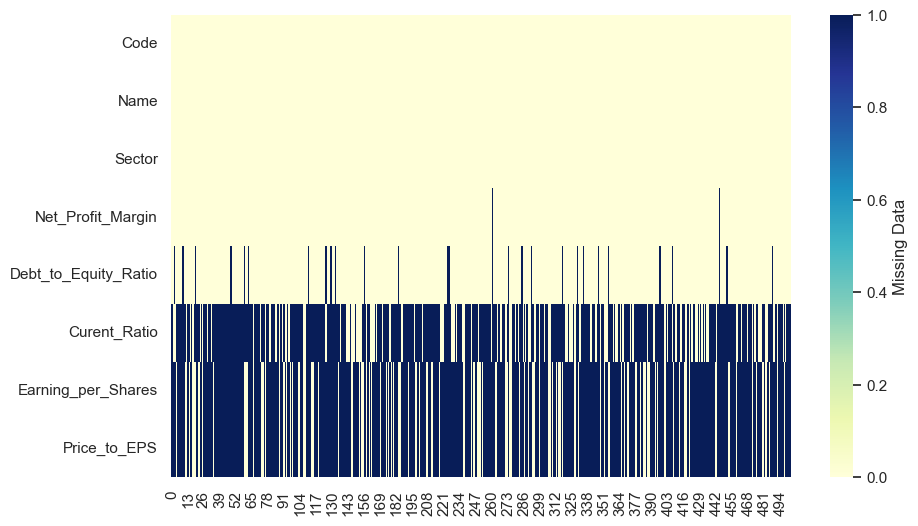

In [87]:
# copy data untuk menghindari perubahan yang tidak diinginkan
edaData = finalData.copy()

# null value
plt.figure(figsize=(10,6))
sns.heatmap(edaData.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
sns.barplot(edaData)

terdapat banyak null value pada kolom current ratio, earning per shares dan P/E